### PROBLEM SUMMARY
The Challenge was divided into the following three parts, each of which had specific requirements that pertained to identifying anomalous entities in different aspects of the Medicare system:
- Part 1: Identify providers that overcharge for certain procedures or regions where procedures are too expensive.
- Part 2: Identify the three providers that are least similar to other providers and the three regions that are least similar to other regions.
- Part 3: Identify 10,000 Medicare patients who are involved in anomalous activities.

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
medcharge_in = pd.read_csv('D:/Business Analytics/PYTHON/Sufiyan/Assignment/9 - End to End Case Study for Python Foundation (Health Care Analytics)/9. End to End Foundation Case Study-1/Medicare_Charge_Inpatient_DRG100_DRG_Summary_by_DRG_FY2011.csv',sep=',')
medcharge_out = pd.read_csv('D:/Business Analytics/PYTHON/Sufiyan/Assignment/9 - End to End Case Study for Python Foundation (Health Care Analytics)/9. End to End Foundation Case Study-1/Medicare_Charge_Outpatient_APC30_Summary_by_APC_CY2011.csv',sep=',')
med_prov_charge_in = pd.read_csv('D:/Business Analytics/PYTHON/Sufiyan/Assignment/9 - End to End Case Study for Python Foundation (Health Care Analytics)/9. End to End Foundation Case Study-1/Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv',sep=',')
med_prov_charge_out = pd.read_csv('D:/Business Analytics/PYTHON/Sufiyan/Assignment/9 - End to End Case Study for Python Foundation (Health Care Analytics)/9. End to End Foundation Case Study-1/Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv',sep=',')

In [4]:
#inpatient_data = pd.merge(med_prov_charge_inpatient,medcharge_inpatient,on='DRG Definition')

In [5]:
#outpatient_data = pd.merge(med_prov_charge_outpatient,medcharge_outpatient,on='APC')

The Data Analysis will be based on financial summary data from 2011 that were made availible by the centers of  Medicare and Medicaid Services

- Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv
- Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv

#### Checking for null values in the dataset

In [6]:
# Medicare_Charge_Outpatient
medcharge_out.isnull().sum()

APC                                    0
Outpatient Services                    0
Average Estimated Submitted Charges    0
Average Total Payments                 0
dtype: int64

In [7]:
# Medicare_Provider_Charge_Outpatient
med_prov_charge_out.isnull().sum()

APC                                           0
Provider Id                                   0
Provider Name                                 0
Provider Street Address                       0
Provider City                                 0
Provider State                                0
Provider Zip Code                             0
Hospital Referral Region (HRR) Description    0
Outpatient Services                           0
Average  Estimated Submitted Charges          0
Average Total Payments                        0
dtype: int64

We can conclude that the both medcharge_out and med_prov_charge_out dataset has no missing values.

In [8]:
# Changing the column names in prober format
outp_col = ['APC', 'Provider_Id', 'Provider_Name', 'Provider_Street_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip_Code',
       'Hospital_Referral_Region_(HRR)_Description', 'Outpatient_Services',
       'Average_Estimated_Submitted_Charges', 'Average_Total_Payments']
med_prov_charge_out.columns = outp_col

### Part 1: Identify providers that overcharge for certain procedures or regions where procedures are too expensive.

#### Part 1A: Highest Cost Variation

In [9]:
# Finding the Standard Deviation and Mean for Outpatient DRG
out_cv = pd.concat(
[med_prov_charge_out[['APC','Average_Estimated_Submitted_Charges']].groupby(by='APC').std().add_suffix('_std'),
 med_prov_charge_out[['APC','Average_Estimated_Submitted_Charges']].groupby(by='APC').mean().add_suffix('_avg')],axis=1)

In [10]:
# Coefficient of Variance - Standard Deviation/Mean
out_cv['Variation'] = out_cv.apply(lambda x: x['Average_Estimated_Submitted_Charges_std']/x['Average_Estimated_Submitted_Charges_avg'],axis=1)

In [11]:
# Procedure with highest variations
out_cv['Variation'].nlargest(3)

APC
0604 - Level 1 Hospital Clinic Visits     1.385150
0698 - Level II Eye Tests & Treatments    1.310444
0019 - Level I Excision/ Biopsy           1.229897
Name: Variation, dtype: float64

In [12]:
# Extracting procedure with highest variations
df1 = med_prov_charge_out[(med_prov_charge_out.APC=='0604 - Level 1 Hospital Clinic Visits')|
                   (med_prov_charge_out.APC=='0698 - Level II Eye Tests & Treatments')|
                   (med_prov_charge_out.APC=='0019 - Level I Excision/ Biopsy')]

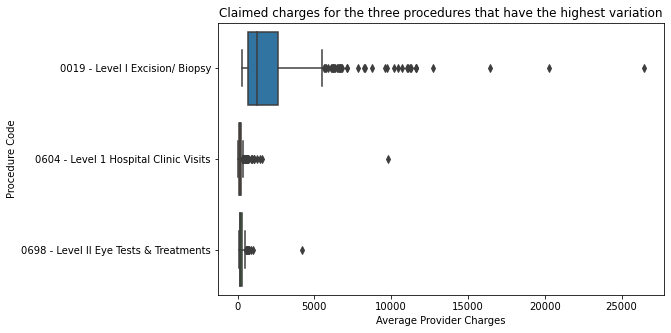

In [13]:
# Creating boxplot to visualize highest cost variation charged by providers 
plt.figure(figsize=(8,5))
sns.boxplot(data=df1,x='Average_Estimated_Submitted_Charges',y='APC')
plt.xlabel('Average Provider Charges')
plt.ylabel('Procedure Code')
plt.title('Claimed charges for the three procedures that have the highest variation')
plt.show()

The three medical procedure that had the most widely varying cost to the patient are **Level 1 Hospital Clinic Visits, Level II Eye Tests Treatments** & **Level I Excision/ Biopsy**. The above figure indicated that some providers charge extremely large amount for certain medical procedures, despite each procedure having relatively low mean and median costs. 

#### Part 1B: Highest Cost Claims by Provider

In [14]:
# Finding the max of Average Covered Charges for OutPatient
max_out = pd.DataFrame(med_prov_charge_out[['APC','Average_Estimated_Submitted_Charges']].groupby(by='APC').max().add_suffix('_max')).reset_index()

In [15]:
# Merging the provider charges data with max of average covered charges for outpatient
df2 = pd.merge(med_prov_charge_out,max_out,on='APC',how='left')

In [16]:
# Identifying the provider that have charged the maximum for outpatient
df2['Max'] = df2.apply(lambda x:1 if (x['Average_Estimated_Submitted_Charges']==x['Average_Estimated_Submitted_Charges_max']) else 0,axis=1)

In [17]:
# Getting number of times a provider has charge max value for procedure
out_max_provider = pd.DataFrame(df2[['Provider_Name','Max']].groupby(by='Provider_Name').sum().add_suffix('_Sum').sort_values(by='Max_Sum',ascending=False).reset_index())

In [18]:
out_max_provider.head(3)

,Provider_Name,Max_Sum
0,COLUMBIA HOSPITAL,2
1,FORT WALTON BEACH MEDICAL CENTER,2
2,CAPITAL HEALTH MEDICAL CENTER - HOPEWELL,2


The three providers who claim the highest charges for the most number of procedures are **Columbia Hospital, Fort Walton Beach Medical Center** & **Capital Health Medical Center - Hopewell**

In [19]:
out_max_provider = out_max_provider[out_max_provider.Max_Sum>0]

In [20]:
#plt.figure(figsize=(12,5))
#plt.pie(out_max_provider.Max_Sum,labels=out_max_provider.Provider_Name,autopct='%1.1f%%')
#plt.show()

#### Part 1C: Highest Cost Claims by Region

In [21]:
#getting number of times a provider has charge max value for procedure
#out_max_region = pd.DataFrame(df2[['Hospital_Referral_Region_(HRR)_Description','Max']].groupby(by='Hospital_Referral_Region_(HRR)_Description').sum().add_suffix('_Sum').sort_values(by='Max_Sum',ascending=False).reset_index())

In [22]:
# Finding the mean of Average Covered Charges for Outpatient by APC and Region
out_region_mean = med_prov_charge_out[['APC','Hospital_Referral_Region_(HRR)_Description','Average_Estimated_Submitted_Charges']].groupby(by=['APC','Hospital_Referral_Region_(HRR)_Description']).mean().add_suffix('_Avg')

In [23]:
# Resetting Index
out_region_mean.reset_index(inplace=True)

In [24]:
out_region_mean.head(3)

,APC,Hospital_Referral_Region_(HRR)_Description,Average_Estimated_Submitted_Charges_Avg
0,0012 - Level I Debridement & Destruction,AK - Anchorage,149.589749
1,0012 - Level I Debridement & Destruction,AL - Birmingham,78.086957
2,0012 - Level I Debridement & Destruction,AR - Fort Smith,80.102439


In [25]:
# Finding the max charges for Outpatient
out_region_max = out_region_mean[['APC','Average_Estimated_Submitted_Charges_Avg']].groupby(by='APC').max().add_suffix('_Max').reset_index()

In [26]:
out_region_max.head()

,APC,Average_Estimated_Submitted_Charges_Avg_Max
0,0012 - Level I Debridement & Destruction,438.307045
1,0013 - Level II Debridement & Destruction,1042.707451
2,0015 - Level III Debridement & Destruction,1478.536545
3,0019 - Level I Excision/ Biopsy,15946.325655
4,0020 - Level II Excision/ Biopsy,15784.975000


In [27]:
# Merging the mean and max will give side by side comparision of region having highest claim
out_region_merge = pd.merge(out_region_mean,out_region_max,on='APC',how='left')

In [28]:
out_region_merge.head(3)

,APC,Hospital_Referral_Region_(HRR)_Description,Average_Estimated_Submitted_Charges_Avg,Average_Estimated_Submitted_Charges_Avg_Max
0,0012 - Level I Debridement & Destruction,AK - Anchorage,149.589749,438.307045
1,0012 - Level I Debridement & Destruction,AL - Birmingham,78.086957,438.307045
2,0012 - Level I Debridement & Destruction,AR - Fort Smith,80.102439,438.307045


In [29]:
# Identifying the region that have charged the maximum for outpatient
out_region_merge['Max'] = out_region_merge.apply(lambda x:1 if (x['Average_Estimated_Submitted_Charges_Avg']==x['Average_Estimated_Submitted_Charges_Avg_Max']) else 0, axis = 1)

In [30]:
out_region_merge[out_region_merge.Max==1].head(3)

,APC,Hospital_Referral_Region_(HRR)_Description,Average_Estimated_Submitted_Charges_Avg,Average_Estimated_Submitted_Charges_Avg_Max,Max
93,0012 - Level I Debridement & Destruction,NE - Omaha,438.307045,438.307045,1
160,0013 - Level II Debridement & Destruction,AL - Dothan,1042.707451,1042.707451,1
582,0015 - Level III Debridement & Destruction,MI - Dearborn,1478.536545,1478.536545,1


In [31]:
# Getting number of times a region has charge max value for procedure
out_region_grouped = out_region_merge[['Hospital_Referral_Region_(HRR)_Description','Max']].groupby(by='Hospital_Referral_Region_(HRR)_Description').sum().add_suffix('_Sum').reset_index()

In [32]:
out_region_grouped.sort_values(by='Max_Sum',ascending=False).head(3)

,Hospital_Referral_Region_(HRR)_Description,Max_Sum
39,CA - Ventura,3
57,FL - Hudson,2
21,CA - Los Angeles,2


The three regions in which patients are charged the highest amount for the most medical procedures are **CA - Ventura, FL - Hudson** & **CA - Los Angeles**.

#### Part 1D: Highest Number of Procedures and Largest Differences between Claims and Reimbursement

Considering -
- Average Estimated Submitted Charges as Claims
- Average Total Payments as Reimbursement

In [33]:
# Deriving the required columns
out_cr_diff = med_prov_charge_out[['APC','Provider_Name','Average_Estimated_Submitted_Charges','Average_Total_Payments']]

In [34]:
# Creating a new column Claim_Diff and calculating the difference between submitted charges and total payments
out_cr_diff['Claim_Diff'] = out_cr_diff.apply(lambda x: x['Average_Estimated_Submitted_Charges']-x['Average_Total_Payments'],axis=1)

In [35]:
out_cr_diff.head(2)

,APC,Provider_Name,Average_Estimated_Submitted_Charges,Average_Total_Payments,Claim_Diff
0,0012 - Level I Debridement & Destruction,EAST ALABAMA MEDICAL CENTER AND SNF,78.086957,21.910435,56.176522
1,0012 - Level I Debridement & Destruction,CENTRAL PENINSULA GENERAL HOSPITAL,149.589749,36.623853,112.965895


In [36]:
# Calculating the mean of Claim_Diff
out_cr_mean = out_cr_diff[['APC','Provider_Name','Claim_Diff']].groupby(by=['APC','Provider_Name']).mean().add_suffix('_Avg').reset_index()

In [37]:
# Average of Claim_Diff by Provider Name and APC
out_cr_mean.head(2)

,APC,Provider_Name,Claim_Diff_Avg
0,0012 - Level I Debridement & Destruction,ALTON MEMORIAL HOSPITAL,91.856818
1,0012 - Level I Debridement & Destruction,ALTRU HOSPITAL,7.259495


In [38]:
# Calculating the max from Claim_Diff_Avg
out_cr_max = out_cr_mean[['APC','Claim_Diff_Avg']].groupby(by='APC').max().add_suffix('_Max').reset_index()

In [39]:
out_cr_max.head(2)

,APC,Claim_Diff_Avg_Max
0,0012 - Level I Debridement & Destruction,827.44
1,0013 - Level II Debridement & Destruction,5175.40


In [40]:
# Merging The mean and max - will give side by side comparison of region having highest claim difference
out_cr_merge = pd.merge(out_cr_mean,out_cr_max,on='APC',how='left').reset_index()

In [41]:
out_cr_merge.head(2)

,index,APC,Provider_Name,Claim_Diff_Avg,Claim_Diff_Avg_Max
0,0,0012 - Level I Debridement & Destruction,ALTON MEMORIAL HOSPITAL,91.856818,827.44
1,1,0012 - Level I Debridement & Destruction,ALTRU HOSPITAL,7.259495,827.44


In [42]:
# Identifying the provider with max Claim_Diff_Avg
out_cr_merge['Max'] = out_cr_merge.apply(lambda x:1 if (x['Claim_Diff_Avg']==x['Claim_Diff_Avg_Max']) else 0, axis=1)

In [43]:
out_cr_merge[out_cr_merge.Max==1].head(2)

,index,APC,Provider_Name,Claim_Diff_Avg,Claim_Diff_Avg_Max,Max
152,152,0012 - Level I Debridement & Destruction,NEBRASKA ORTHOPAEDIC HOSPITAL,827.44,827.44,1
1265,1265,0013 - Level II Debridement & Destruction,RUSSELLVILLE HOSPITAL,5175.40,5175.40,1


In [44]:
# Getting the required columns
out_cr_merge_grouped = out_cr_merge[['Provider_Name','Max']].groupby(by='Provider_Name').sum().add_suffix('_Sum').reset_index()

In [45]:
out_cr_merge_grouped.sort_values(by='Max_Sum',ascending=False).head(3)

,Provider_Name,Max_Sum
484,COLUMBIA HOSPITAL,2
799,FORT WALTON BEACH MEDICAL CENTER,2
327,CAPITAL HEALTH MEDICAL CENTER - HOPEWELL,2


The three providers who have the highest number of procedures with the largest difference between their claimed charges to patients and their reimbursement from Medicare are **Columbia Hospital, Fort Walton Beach Medical Center** & **Capital Health Medical Center - Hopewell**

#### Part 2: Identify the three providers that are least similar to other providers and the the three regions that are least similar to other region

#### Part 2A: Providers Least Like Others

In [46]:
# Getting the required columns
out_data = med_prov_charge_out[['APC','Provider_Name','Provider_State','Hospital_Referral_Region_(HRR)_Description','Outpatient_Services','Average_Estimated_Submitted_Charges','Average_Total_Payments']]

In [47]:
# Renaming columns for better understanding
out_data.rename(columns={'APC':'Procedure','Hospital_Referral_Region_(HRR)_Description':'Region','Outpatient_Services':'Count_of_Services','Average_Estimated_Submitted_Charges':'Charges','Average_Total_Payments':'Payments'},inplace=True)

In [48]:
# Rounding off Charges and Payments columns
out_data['Charges'] = out_data.Charges.round(2)
out_data['Payments'] = out_data.Payments.round(2)

In [49]:
# Aggregating some columns by providers
out_data_group_provider = out_data.groupby(by=['Provider_Name']).agg({'Procedure':'nunique','Provider_State':'nunique','Region': 'nunique',
'Count_of_Services':'sum', 
'Charges':'sum' , 
'Payments':'sum'})

In [50]:
out_data_group_provider.reset_index(inplace=True)

In [51]:
out_data_group_provider.head(2)

,Provider_Name,Procedure,Provider_State,Region,Count_of_Services,Charges,Payments
0,ABBEVILLE GENERAL HOSPITAL,7,1,1,785,4705.01,1177.85
1,ABBOTT NORTHWESTERN HOSPITAL,24,1,1,13329,41719.93,7695.52


K Means Clustering is exploratory data analysis technique. 
This is non-hierarchical method of grouping objects together

In [52]:
out_provider_num = out_data_group_provider.select_dtypes(include=['int64','float64'])

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [54]:
# Scaling the data
sc = StandardScaler()
out_provider_scaled = sc.fit_transform(out_provider_num)

In [55]:
# Principal Componant Analysis
pc=PCA(n_components=3)
out_provider_pca = pc.fit(out_provider_scaled)

In [56]:
reduced_cr = pc.fit_transform(out_provider_scaled)

In [57]:
reduced_cr.shape

(3007, 3)

In [58]:
out_provider_scaled.shape

(3007, 6)

In [59]:
pd.Series(pc.explained_variance_ratio_,index=['PC_' + str(i) for i in range(3)])

PC_0    0.584508
PC_1    0.244435
PC_2    0.107230
dtype: float64

#### Silhouette Coefficient

In [60]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [61]:
k_range = range(3,25)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k,random_state=1)
    km.fit(out_provider_scaled)
    scores.append(metrics.silhouette_score(out_provider_scaled,km.labels_))

In [62]:
scores

[0.4011491014501958,
 0.4145702777585026,
 0.4348130319784132,
 0.35849702332227334,
 0.32814790829843693,
 0.3298684870634567,
 0.33671917738233953,
 0.33985578528734095,
 0.321663911848059,
 0.32792048238417604,
 0.31061067385942726,
 0.31059635076855646,
 0.3086987923217563,
 0.28843922661803684,
 0.29849893625971785,
 0.29092311749479505,
 0.29969892723378233,
 0.2860029863430676,
 0.2987405195190005,
 0.28928562909906685,
 0.2924062706469097,
 0.2866446540293897]

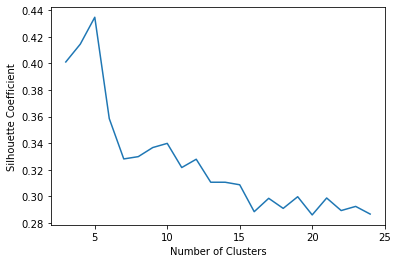

In [63]:
plt.plot(k_range,scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

We will be using Silhouette Coefficient to get the most scattered cluster i.e. least coeffient 
to get the outliers.

Using 20 custers for cluster analysis since it is having least coeffcient.

In [64]:
km_20 = KMeans(n_clusters=20,random_state=123)
km_20.fit(reduced_cr)
km_20.labels_

array([ 8, 12, 11, ..., 19,  6, 17])

In [65]:
pd.Series(km_20.labels_).value_counts()

11    476
2     475
17    435
19    391
3     285
8     271
0     209
15    136
12    117
4      47
13     39
6      32
14     28
16     22
5      18
1      11
9       5
18      5
10      3
7       2
dtype: int64

Text(0.5, 0, 'PC_20')

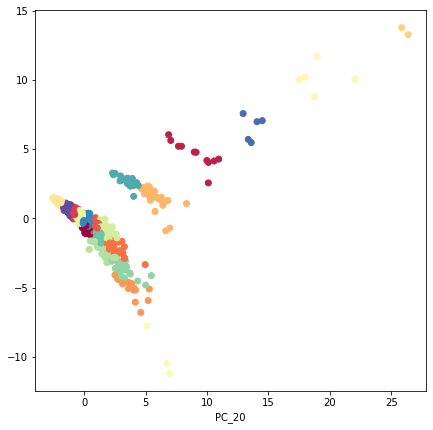

In [67]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_20.labels_,cmap='Spectral',alpha=1)
plt.xlabel('PC_20')

In [68]:
cluster_df_20=pd.concat([out_data_group_provider, pd.Series(km_20.labels_, name='Cluster_20')], axis=1)

In [69]:
cluster_df_20.to_csv('cluster_df_20_2.csv')

The three providers that are least like all others are the **Cleveland Clinic, Good Samaritan Hospital** &
**Scott & White Memorial Hospital**

#### Part 2A: Regions Least Like Others

In [74]:
# Aggregating some columns by regions
out_data_group_region =out_data.groupby(by=['Region']).agg({'Procedure':'nunique','Provider_State':'nunique','Provider_Name': 'nunique',
'Count_of_Services':'sum', 
'Charges':'sum' , 
'Payments':'sum'})

In [75]:
out_data_group_region.reset_index(inplace=True)

out_data_group_region.head(2)

,Region,Procedure,Provider_State,Provider_Name,Count_of_Services,Charges,Payments
0,AK - Anchorage,22,1,6,25264,106884.93,24222.52
1,AL - Birmingham,27,2,38,98040,882933.99,119137.00


In [76]:
out_region_num = out_data_group_region.select_dtypes(include=['int64','float64'])

In [77]:
# Scaling the data
sc = StandardScaler()
out_region_scaled = sc.fit_transform(out_region_num)

In [78]:
# Principal Componant Analysis
pc=PCA(n_components=3)
out_region_pca = pc.fit(out_region_scaled)

In [79]:
reduced_cr = pc.fit_transform(out_region_scaled)

In [80]:
reduced_cr.shape

(304, 3)

In [81]:
out_region_scaled.shape

(304, 6)

In [82]:
pd.Series(pc.explained_variance_ratio_,index=['PC_' + str(i) for i in range(3)])

PC_0    0.654877
PC_1    0.159107
PC_2    0.106903
dtype: float64

#### Silhouette Coefficient

In [83]:
k_range = range(3,25)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k,random_state=1)
    km.fit(out_region_scaled)
    scores.append(metrics.silhouette_score(out_region_scaled,km.labels_))

In [84]:
scores

[0.375478988810335,
 0.37756386611844345,
 0.3699014789064492,
 0.35933202508465206,
 0.3775689113350811,
 0.34192528182505827,
 0.33339023667509554,
 0.34987177255167473,
 0.3263033248442749,
 0.3313767638888258,
 0.31307169100949517,
 0.32206343676197846,
 0.33554685829762615,
 0.2918048091824904,
 0.31039699702505036,
 0.3119222286557435,
 0.3030340210784949,
 0.2976031439925273,
 0.30590875335096873,
 0.30145199428137603,
 0.2987537793378989,
 0.29819043483354035]

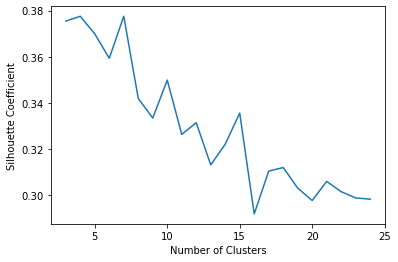

In [85]:
plt.plot(k_range,scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

We will be using Silhouette Coefficient to get the most scattered cluster i.e. least coeffient 
to get the outliers.

Using 16 custers for cluster analysis since it is having least coeffcient.

In [86]:
km_16 = KMeans(n_clusters=16,random_state=124)
km_16.fit(reduced_cr)
km_16.labels_

array([ 6,  5, 14,  1,  1,  6,  2, 10, 10,  7,  6, 14,  6,  5, 12, 11, 11,
        6,  6,  6, 11,  4,  6,  2,  7,  6,  6,  7,  2,  7,  7,  0, 11, 12,
        0,  2, 12, 12, 12,  6, 12,  6,  8, 10, 12,  6,  2, 11,  7,  8,  0,
       10, 12,  6,  3,  0, 11, 12,  8, 12,  7,  6,  3, 11, 12,  8, 11,  6,
        1, 11,  2,  9,  1, 10, 11, 10, 10, 11,  6,  1, 11,  2,  0,  2, 10,
        6,  1,  6,  2,  2, 11,  3,  6,  0,  6,  6,  0,  0, 11, 11,  2, 14,
       10, 11,  3,  2, 12,  6, 11,  2, 11,  7,  2,  7,  8,  2, 10,  2,  6,
       12, 11,  2,  6,  6, 11,  1, 10, 15, 11,  0,  2,  0,  8,  0,  6,  0,
       11, 11,  6,  6,  2,  2,  2,  6,  0, 11, 12,  2, 11,  5,  0,  2, 11,
        6,  0, 14,  5,  1,  5,  6,  2,  7, 10,  2, 10,  1,  2,  6,  0,  8,
        8,  2, 11, 11,  7,  2,  8, 11,  1,  2, 12,  6,  8,  1,  0,  7,  1,
        1,  6, 11,  6, 10,  8,  1,  6, 13, 11, 11, 11,  3,  2,  3,  0,  0,
        6, 11,  6,  8,  3,  3, 11,  2,  6,  8, 10,  2,  3,  8, 12,  6,  1,
        8,  2,  8,  2,  0

In [87]:
pd.Series(km_16.labels_).value_counts()

6     59
2     46
11    41
0     26
1     24
10    22
12    19
8     18
7     16
3     10
5      8
14     6
13     3
9      3
4      2
15     1
dtype: int64

Text(0.5, 0, 'PC_16')

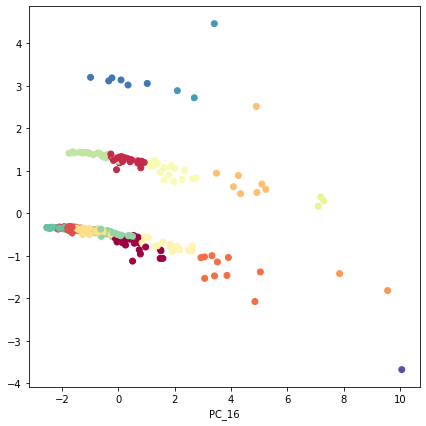

In [88]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_16.labels_,cmap='Spectral',alpha=1)
plt.xlabel('PC_16')

In [89]:
cluster_df_16=pd.concat([out_data_group_region, pd.Series(km_16.labels_, name='Cluster_16')], axis=1)

In [90]:
cluster_df_16.to_csv('cluster_df_16_region.csv')

The three providers that are least like all others are the **CA - Los Angeles, MA - Boston** & **TX - Houston**


In [ ]:
### Part 3: Identify 10000 medicare patients who are involved in anomalous activities .